#  IMDB Feedback Classifier Evaluation
I'll apply Naive Bayes Classifier to analyze IMDB feedbacks by sentiment (either positive or negative) and will evaluate the accuracy using cross validation method. 

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import re
import warnings
warnings.filterwarnings('ignore')

## 1. Preparing data for Classification

In [3]:
# load the data
path = r'C:\Users\hafeez_poldz\Desktop\Thinkful\Unit 2\datas\sentiment\imdb_labelled.txt'
df = pd.read_csv(path, delimiter = '\t', header = None)
df.columns = ['reviews', 'sentiment']

# standartize the review columns
df['reviews'] = df['reviews'].str.lower()
df1 = df.copy()

# I'll use regex to group similar terms rather to go with the long list of keywords
keywords = ([r"\b(best|super(b)|great|worth|original|[^t] recommend(ed)?|must see|very well)\b", "great"],
            [r"\b(excellent|impressive|amaz(ing|ed)|enjoy(ed|able)|fascinat(ing|ed)|legendary|perfect(ly|ed|ion)|good|nice)\b", "excellent"],
            [r"\b(mindblowing|thought provoking|intriguing)\b", "mindblowing"],
            [r"\bcomical\b", "comic"],
            [r"\b(remarkable|interesting|imaginative)\b", "imaginative"],
            [r"\b(incredib(le|ly)|unbelivab(le|ly))\b", "unbelivable"],
            [r"\b(unpretentious|outstanding|adorable|wonderful|surpris(ing|ed))\b", "wonderful"])

# see if the keyword/s are in the review
for pattern, word in keywords:
    df1[str(word)] = df1['reviews'].str.contains(pattern, case = False)
df1.head()

,reviews,sentiment,great,excellent,mindblowing,comic,imaginative,unbelivable,wonderful
0,"a very, very, very slow-moving, aimless movie ...",0,False,False,False,False,False,False,False
1,not sure who was more lost - the flat characte...,0,False,False,False,False,False,False,False
2,attempting artiness with black & white and cle...,0,False,False,False,False,False,False,False
3,very little music or anything to speak of.,0,False,False,False,False,False,False,False
4,the best scene in the movie was when gerardo i...,1,True,False,False,False,False,False,False


## 2. Naive Bayes Classicification. 
This data is binary / boolean, so I'll apply Bernoulli classifier.

In [4]:
# define data and target variables
data = df1.loc[:, 'great':]
y_true = df['sentiment']

# instantiate Bernoulli model
bnb = BernoulliNB()

# fit the model to the data
bnb.fit(data, y_true)

# classify, storing the predictions in a new variable
y_pred = bnb.predict(data)

# print the results
print(" Number of mislabeled points out of a total {} points : {}".format(data.shape[0], 
                                                                                     (y_true != y_pred).sum()))

 Number of mislabeled points out of a total 748 points : 278


## 3. Evaluation of Classifier
I already have model. Let see the accuracy. I doubt that is want I wanted.


In [5]:
# check the accyracy
print("accuracy score: {}%".format(round(accuracy_score(y_true, y_pred)*100)))

accuracy score: 63.0%


In [6]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

print(f"{cm[0,0]} true negatives, and {cm[1,0]} false negatives")
print(f"{cm[1,1]} true positives, and {cm[0,1]} false positives")

print('correcly identified positives: {}%'.format(round(np.divide(cm[1,1], (cm[1,0]+cm[1,1]))*100)))
print('correctly identified negatives: {}%'.format(round(np.divide(cm[0,0], (cm[0,0]+cm[0,1]))*100)))

332 true negatives, and 248 false negatives
138 true positives, and 30 false positives
correcly identified positives: 36.0%
correctly identified negatives: 92.0%


Th accuracy is not really good. The confusion matrix shows that my classification defined 248 positive reviews as negatives and 30 actual negative reviews as positives which is not good. In total, I have 278 false alarms. Only 36% of the true positive reviews were predicted by the classifier correctly. Let's test the data with houldout groups

In [7]:
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, y_true, test_size=0.2, random_state=42)
print('Accouracy with 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, y_true).score(data, y_true)))

Accouracy with 20% Holdout: 0.6066666666666667
Testing on Sample: 0.6283422459893048


I trained 80% and tested 20% of the data, and received an accuracy of 60%. This is even less than the accuracy of the test on the entire sample. 
Cross validation is a more robust version of holdout groups. I'll calculate cross validation score for 9 folds 

In [8]:
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(bnb, data, y_true, cv = 9)
print(cvs)
print('mean: {}, std: {}'.format(np.mean(cvs), np.std(cvs)))

[0.60714286 0.60714286 0.71084337 0.65060241 0.63855422 0.65060241
 0.57831325 0.57831325 0.6097561 ]
mean: 0.6256967475010379, std: 0.039565466936094744


The array of scores has low standard deviation, and the average accuracy is still around 63%

## 3.1 Model 1: Feature improvement
I'll try to identify which keywords don't exist in my keywords list and drop them. I'll plot the correlation matrix of these keywords and group moderately correlated keyword using regex.

In [9]:
# copy the dataframe
df2 = df.copy()

df2.columns = ['reviews', 'sentiment']

keywords1 = ['best', 'super', 'first rate', 'original', 'insightful', 'recommend', 'very well', 'excellent', 'impressive',
           'dazzling', 'amazing', 'enjoyed', 'perfect', 'must see', 'great', 'mindblowing', 'intriguing', 'good', 
           'legendary', 'remarkable', 'interesting', 'imaginative', 'ubelievable', 'incredible', 'outstanding', 'adorable',
           'nice', 'unpretetious', 'wonderful', 'surprising', 'superb', 'lovely', 'loved','comical', 'recommended', 'thought provoking',
            'imaginative', 'adorable', 'hilarious', 'brilliant', 'beautiful', 'wonderful','amazing']

existing_keywords = keywords1.copy()

for key in keywords1:
    df2[key] = df2.reviews.str.contains(' ' + str(key) + ' ', case=False)
    # if reviews do not contain a word in keywords , it will be dropped
    if df2[key].nunique() == 1:
        df2 = df2.drop([key], axis=1)
        existing_keywords.remove(key)
        
        print(key)

first rate
insightful
dazzling
intriguing
legendary
ubelievable
outstanding
unpretetious
comical


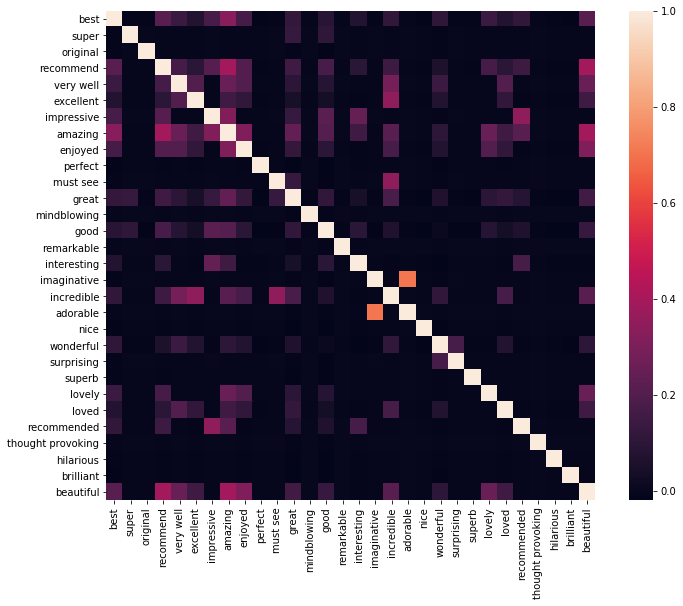

In [10]:
#df2.head()
# check the correlation among existing keywords
corr = df2.loc[:, 'best':].corr()

# plot heatmap
fig, ax = plt.subplots(figsize = (12, 9))
_ = sns.heatmap(corr, square = True)

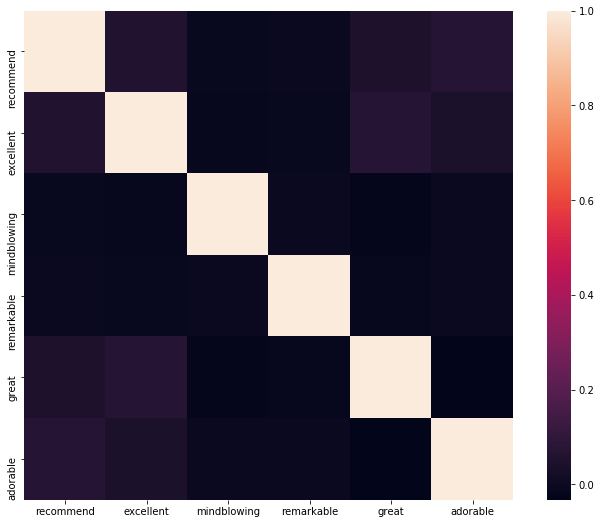

In [11]:
df3 = df.copy()

existing_keywords_groups = ([r"\b(recommend|interesting|impressive|amaz(ing|ed))\b", "recommend"],
            [r"\b(wonderful|surprising|incredible|love(d|ly)|(must see)|enjoy(ed|able)|excellent)\b", "excellent"],
            [r"\b(mindblowing|(thought provoking))\b", "mindblowing"],
            #[r"\b\b", "perfect"],
            [r"\bremarkable\b", "remarkable"],
            [r"\b(best|great|good|nice|(very well)|supe(r|rb)|perfect(ly|ion))\b", "great"],
            [r"\b(imaginative|adorable)\b", "adorable"])

# see if the keyword/s are in the review
for pattern, word in existing_keywords_groups:
    df3[str(word)] = df3['reviews'].str.contains(pattern, case = True)
    
fig, ax = plt.subplots(figsize = (12, 9))
_ = sns.heatmap(df3.loc[:,'recommend':].corr(), square = True)

In [12]:
data = df3.loc[:, 'recommend':]
y_true= df3['sentiment']

# fit our model to the data
bnb.fit(data, y_true)

# classify, storing the result in a new variable
y_pred = bnb.predict(data)

# print the results
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (y_true != y_pred).sum()))
print('accuracy: {}%'.format(round(accuracy_score(y_true, y_pred)*100), 4))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(f"{cm[0,0]} true negatives, and {cm[1,0]} false negatives")
print(f"{cm[1,1]} true positives, and {cm[0,1]} false positives")

print('correcly identified positives: {}%'.format(round(np.divide(cm[1,1], (cm[1,0]+cm[1,1]))*100)))
print('correctly identified negatives: {}%'.format(round(np.divide(cm[0,0], (cm[0,0]+cm[0,1]))*100)))

Number of mislabeled points out of a total 748 points : 273
accuracy: 64.0%
333 true negatives, and 244 false negatives
142 true positives, and 29 false positives
correcly identified positives: 37.0%
correctly identified negatives: 92.0%


In the second model I could improve accuracy and correctly identified positives by 1% which is not the best.

## 3.2 Model 2: Most Common Positive Keywords
Now I try to define most common keywords (mostly positive adjectives) in positive reviews. I plan to add more keywords which I did not have in my previous keywords groups.

In [13]:
# find most common words in positive reviews
df4 = df.copy()
good_reviews = df4[df4.sentiment==1]
print(pd.Series(' '.join(good_reviews['reviews']).split()).value_counts()[:200])

the            404
and            249
a              229
of             184
is             145
i              139
this           134
to             111
in             108
it              85
was             72
that            65
movie           64
film            59
with            48
as              47
0               46
for             43
but             40
are             38
you             34
it's            33
good            31
one             30
on              30
very            27
so              26
great           26
an              26
at              26
              ... 
doesn't          5
get              5
me               5
bad              5
subtle           5
we               5
absolutely       5
joy              5
should           5
brilliant        5
fine             5
movie,           5
terrific         5
probably         5
now              5
silent           5
however,         5
does             5
time.            5
nice             5
years.           5
black       

It's probably a good idea to create 'rating' feature as people are likely to mention the rating what they want to give to the movie. Moreover, I add delightful, entertaining, gem, fanciful, cool, greatest, gloriously keywords to the groups.

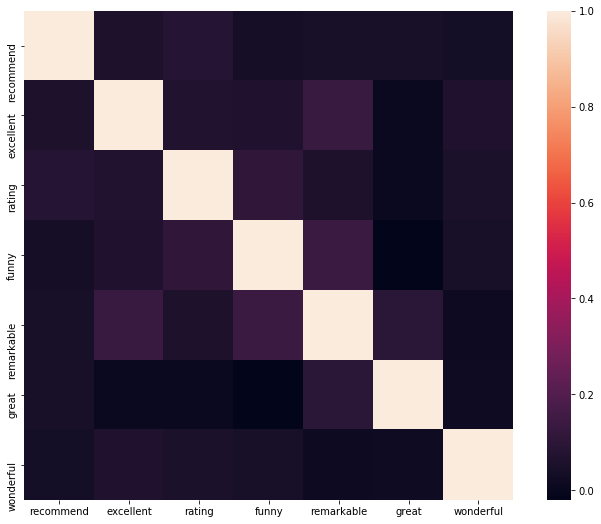

In [14]:
# create keywords groups using regex
most_common_keywords_groups = ([r"\b(recommend(ed)?|worth|lik(e|ed))\b", "recommend"],
            [r"\b(surprising|incredible|(must see)|enjoy(ed)?|interesting|excellent|delightful)\b", "excellent"],
            [r"\b(10|9|8|7)\b", "rating"],
            [r"\b(funny|entertaining|love(d|ly)|gem|fanciful)\b", "funny"],
            [r"\b(mindblowing|thought-provoking|remarkable|memorable|tru(e|ly)|impressive|masterpiece)\b", "remarkable"],
            [r"\b(best|great(est)|better|good|pretty|nice|very|cool(est)|well|supe(r|rb)|perfect)\b", "great"],
            [r"\b(imaginative|glorious(ly)?|adorable|hilarious|brilliant|beautiful|wonderful|amazing|fantastic)\b", "wonderful"])

# see if the keyword/s are in the review
for pattern, word in most_common_keywords_groups:
    df4[str(word)] = df4['reviews'].str.contains(pattern, case = True)
    
fig, ax = plt.subplots(figsize = (12, 9))
_ = sns.heatmap(df4.loc[:,'recommend':].corr(), square = True)

In [97]:
data = df4.loc[:, 'recommend':]
y_true= df4['sentiment']

# fit our model to the data
bnb.fit(data, y_true)

# classify, storing the result in a new variable
y_pred = bnb.predict(data)

# print the results
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (y_true != y_pred).sum()))
print('accuracy: {}%'.format(round(accuracy_score(y_true, y_pred)*100), 4))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(f"{cm[0,0]} true negatives, and {cm[1,0]} false negatives")
print(f"{cm[1,1]} true positives, and {cm[0,1]} false positives")

print('correcly identified positives: {}%'.format(round(np.divide(cm[1,1], (cm[1,0]+cm[1,1]))*100)))
print('correctly identified negatives: {}%'.format(round(np.divide(cm[0,0], (cm[0,0]+cm[0,1]))*100)))

Number of mislabeled points out of a total 748 points : 237
accuracy: 68.0%
279 true negatives, and 154 false negatives
232 true positives, and 83 false positives
correcly identified positives: 60.0%
correctly identified negatives: 77.0%


This time I have 4% imporevement in accuracy and 23% increase in correctly identified positives. This result also is not the best but definitely better than previous models.

## 3.3 Model 3: Unique Positive Keywords & Unique Negative Keywords
This time I'll identify most common positive and negative keywords in feedbacks. Then I'll get unique keywords from both groups to improve the accuracy by dropping the keywords which are in both groups. I plan to add more keywords which I did not have in my previous keywords groups.

In [187]:
df5 = df.copy()
good_reviews = df5[df5.sentiment==1]
most_common_500_good = pd.Series(' '.join(good_reviews['reviews']).split()).value_counts()[:500]

bad_reviews = df5[df5.sentiment == 0]
most_common_500_bad = pd.Series(' '.join(bad_reviews['reviews']).split()).value_counts()[:500]

bad_list = most_common_500_bad.reset_index().iloc[:, 0].tolist()
bad_list = set(bad_list)

good_list = most_common_500_good.reset_index().iloc[:, 0].tolist()
good_list = set(good_list)

good_uniques = good_list - bad_list
bad_uniques = bad_list - good_list

In [188]:
# create keywords groups using regex
positive_keywords_groups = ([r"\b(recommend(ed)?|worth|lik(e|ed)|subtle|special|highly|deserved)\b", "recommend"],
            [r"\b(surprising|incredible|(must see)|enjoy(ed)?|interesting|excellent|delightful|exceptional)\b", "excellent"],
            [r"\b(10|9|8|7)\b", "rating"],
            [r"\b(joy|entertaining|love(d|ly)|gem|fanciful|comedy|decent|effective)\b", "loved"],
            [r"\b(mindblowing|thought-provoking|remarkable|memorable|truly|exactly|absolutely|definitely|impressive|masterpiece)\b", "remarkable"],
            [r"\b(best|great(est)|better|right|fine|good|pretty|nice|cool(est)|supe(r|rb)|perfect)\b", "great"],
            [r"\b(imaginative|glorious(ly)?|adorable|hilarious|brilliant|beautiful(ly)?|wonderful|amazing|fantastic)\b", "wonderful"])

negative_keywords_groups = ([r"\b(cheap|lack(ed|s)|crap|garbage|bad|poor|not|n't|worse)\b", "bad"],
                           [r"\b(stupid|annoying|horrible|never|terrib(ly|le)|disaster|awful|disappointed|suck(s|ed)|simply|boring)\b", 'terrible'],
                           [r"\b(whatever|barely|slow_moving|bored|waste(d)?|nothing|predictable)\b", "waste"],
                           [r"\b(unfortunately|overacting|pitiful)\b", 'unfrotunately'])

df5 = df.copy()
# see if the keyword/s are in the review
for pattern, word in positive_keywords_groups:
    df5[str(word)] = df5['reviews'].str.contains(pattern, case = True)
for pattern, word in negative_keywords_groups:
    df5[str(word)] = df5['reviews'].str.contains(pattern, case = False)

In [189]:
data = df5.loc[:, 'recommend':]
y_true= df5['sentiment']

# fit our model to the data
bnb.fit(data, y_true)

# classify, storing the result in a new variable
y_pred = bnb.predict(data)

# print the results
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (y_true != y_pred).sum()))
print('accuracy: {}%'.format(round(accuracy_score(y_true, y_pred)*100), 4))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(f"{cm[0,0]} true negatives, and {cm[1,0]} false negatives")
print(f"{cm[1,1]} true positives, and {cm[0,1]} false positives")

print('correcly identified positives: {}%'.format(round(np.divide(cm[1,1], (cm[1,0]+cm[1,1]))*100)))
print('correctly identified negatives: {}%'.format(round(np.divide(cm[0,0], (cm[0,0]+cm[0,1]))*100)))

Number of mislabeled points out of a total 748 points : 212
accuracy: 72.0%
177 true negatives, and 27 false negatives
359 true positives, and 185 false positives
correcly identified positives: 93.0%
correctly identified negatives: 49.0%


As we can see, the accuracy rate increased by 4% and in 93% cases, the model identifies positive feedbacks correctly. But now I have a problem with correctly identified negatives which went down from 77% to 49%. This is because the negative keywords groups are not perfect and not all negative keywords are added to the groups.